In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
import matplotlib.pylab as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split


In [4]:
!pip install pymystem3

In [5]:
pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 63.2 MB/s eta 0:00:00


In [6]:
pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=12cab3ef5ded0a81a10728a8640bfac108cc638289f9007d8d7576a2d0778aca
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt


In [7]:
from nltk.stem.snowball import SnowballStemmer
import pymorphy3
import pymorphy2
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [8]:
train = pd.read_csv('/content/train_candles.csv')
train = train.dropna().drop_duplicates()
train.head()

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,target_direction_20d
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,0.004896,1,0.071726,1
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,-0.010962,0,0.048477,1
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,-0.007635,0,0.048522,1
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,-0.014892,0,0.096550,1
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,0.044344,1,0.104056,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23118 entries, 0 to 23117
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  23118 non-null  float64
 1   close                 23118 non-null  float64
 2   high                  23118 non-null  float64
 3   low                   23118 non-null  float64
 4   volume                23118 non-null  int64  
 5   begin                 23118 non-null  object 
 6   ticker                23118 non-null  object 
 7   target_return_1d      23118 non-null  float64
 8   target_direction_1d   23118 non-null  int64  
 9   target_return_20d     23118 non-null  float64
 10  target_direction_20d  23118 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 1.9+ MB


In [10]:
# candles = pd.read_csv('/content/candles.csv')
# candles = candles.dropna().drop_duplicates()
# candles.head()

Для горизонта 1 день:
target_return_1d - непрерывная доходность на 1 день вперед

target_direction_1d - бинарная направление движения (1 = рост, 0 = падение)

Для горизонта 20 дней:
target_return_20d - непрерывная доходность на 20 дней вперед

target_direction_20d - бинарная направление движения (1 = рост, 0 = падение)

In [11]:
train_text = pd.read_csv('/content/train_news.csv')
train_text=train_text.drop('Unnamed: 0', axis=1).dropna().drop_duplicates()
train_text.head()

,publish_date,title,publication
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл..."
3,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...
4,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...


работа с текстовыми данными



In [12]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""
    cleaned_text = re.sub(r'[^А-Яа-я\s]+', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

train_text['title'] = train_text['title'].apply(clean_text)
train_text['publication'] = train_text['publication'].apply(clean_text)
train_text.head(3)

,publish_date,title,publication
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли Ключевые российские нефтег...
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли Ключевые российские сталел...
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,Председатель правления Газпрома Алексей Миллер...


In [14]:
# приведение заглавных букв к строчным
import nltk
nltk.download('punkt_tab')

train_text['title'] = train_text['title'].apply(lambda x: ' '.join(word_tokenize(x.lower())))
train_text['publication'] = train_text['publication'].apply(lambda x: ' '.join(word_tokenize(x.lower())))
train_text.head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,publish_date,title,publication
0,2020-01-01 14:00:00,ключевые российские нефтегазовые компании смот...,тенденции в отрасли ключевые российские нефтег...
1,2020-01-02 15:00:00,ммк выгодно отличает высокая экспозиция на вну...,тенденции в отрасли ключевые российские сталел...
2,2020-01-03 10:13:10,контракты на поставку газа в белоруссию и тран...,председатель правления газпрома алексей миллер...
3,2020-01-03 13:26:29,пао фосагро внеочередное общее собрание,дата и время воса дата фиксации дополнительная...
4,2020-01-03 13:44:03,пао ммк внеочередное общее собрание итоги,дата и время собрания дата фиксации дополнител...


In [15]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopword = stopwords.words("russian")
morph = Mystem()
stemmer = SnowballStemmer("russian")


def lemmatize_and_stem(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopword:
            token = token.strip()
            token = morph.lemmatize(token)[0]
            token = stemmer.stem(token)
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

<>:1: SyntaxWarning: invalid escape sequence '\]'
<>:1: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-607517100.py:1: SyntaxWarning: invalid escape sequence '\]'
  patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [16]:
train_text['title'] = train_text['title'].astype(str)
train_text['publication'] = train_text['publication'].astype(str)
train_text['title'] = train_text['title'].apply(lemmatize_and_stem)
train_text['publication'] = train_text['publication'].apply(lemmatize_and_stem)

In [17]:
train_text.head()

,publish_date,title,publication
0,2020-01-01 14:00:00,"[ключев, российск, нефтегазов, компан, смотрет...","[тенденц, отрасл, ключев, российск, нефтегазов..."
1,2020-01-02 15:00:00,"[ммк, выгодн, отлича, высок, экспозиц, внутрен...","[тенденц, отрасл, ключев, российск, сталелитей..."
2,2020-01-03 10:13:10,"[контракт, поставк, газ, белорусс, транз, прод...","[председател, правлен, газпр, алекс, миллер, ч..."
3,2020-01-03 13:26:29,"[па, фосагр, внеочередн, общ, собран]","[дат, врем, вос, дат, фиксац, дополнительн, ин..."
4,2020-01-03 13:44:03,"[па, ммк, внеочередн, общ, собран, итог]","[дат, врем, собран, дат, фиксац, дополнительн,..."


In [18]:
train_text['title'] = train_text['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
train_text['publication'] = train_text['publication'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

print(train_text['title'].head())
print(train_text['publication'].head())
train_text['clean_text'] = train_text['title'] + " " + train_text['publication']

train_text['clean_text'] = train_text['clean_text'].str.strip()
train_text = train_text[train_text['clean_text'] != ""]

train_text = train_text[train_text['clean_text'].str.len() > 0]

docs = train_text['clean_text'].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)
X_text = vectorizer.fit_transform(docs)

print(f"Создано {X_text.shape[1]} TF-IDF признаков для {X_text.shape[0]} документов")




print("Типы данных:")
print(f"title: {type(train_text['title'].iloc[0])}")
print(f"publication: {type(train_text['publication'].iloc[0])}")
print("\nПримеры текстов:")
for i in range(3):
    print(f"Документ {i}: {train_text['clean_text'].iloc[i][:100]}...")

0    ключев российск нефтегазов компан смотрет выго...
1       ммк выгодн отлича высок экспозиц внутрен рынок
2       контракт поставк газ белорусс транз продля год
3                      па фосагр внеочередн общ собран
4                    па ммк внеочередн общ собран итог
Name: title, dtype: object
0    тенденц отрасл ключев российск нефтегазов комп...
1    тенденц отрасл ключев российск сталелитейн ком...
2    председател правлен газпр алекс миллер чрезвыч...
3    дат врем вос дат фиксац дополнительн информац ...
4    дат врем собран дат фиксац дополнительн информ...
Name: publication, dtype: object
Создано 5000 TF-IDF признаков для 24127 документов
Типы данных:
title: <class 'str'>
publication: <class 'str'>

Примеры текстов:
Документ 0: ключев российск нефтегазов компан смотрет выгодн относительн аналог тенденц отрасл ключев российск н...
Документ 1: ммк выгодн отлича высок экспозиц внутрен рынок тенденц отрасл ключев российск сталелитейн компан сох...
Документ 2: контракт поставк

In [19]:

train_text['date'] = pd.to_datetime(train_text['publish_date']).dt.date
train['date'] = pd.to_datetime(train['begin']).dt.date

print("Колонки в train_text:", train_text.columns.tolist())
print("Колонки в train:", train.columns.tolist())
print("\nДиапазон дат в train_text:", train_text['date'].min(), "до", train_text['date'].max())
print("Диапазон дат в train:", train['date'].min(), "до", train['date'].max())

daily_news = train_text.groupby('date')['clean_text'].apply(lambda x: ' '.join(x)).reset_index()
#ВЕКТОРАЙЗЕР
daily_docs = daily_news['clean_text'].tolist()
daily_vectorizer = TfidfVectorizer(max_features=1000)
X_daily = daily_vectorizer.fit_transform(daily_docs)

daily_tfidf = pd.DataFrame(X_daily.toarray(), columns=daily_vectorizer.get_feature_names_out())
daily_tfidf['date'] = daily_news['date'].values

df = pd.merge(
    train,
    daily_tfidf,
    on='date',
    how='left'
)


print(f"Новостных фичей: {len([col for col in df.columns if not col in ['date', 'begin', 'ticker']])}")
df.shape

Колонки в train_text: ['publish_date', 'title', 'publication', 'clean_text', 'date']
Колонки в train: ['open', 'close', 'high', 'low', 'volume', 'begin', 'ticker', 'target_return_1d', 'target_direction_1d', 'target_return_20d', 'target_direction_20d', 'date']

Диапазон дат в train_text: 2020-01-01 до 2025-04-13
Диапазон дат в train: 2020-06-19 до 2025-04-15
Новостных фичей: 1009


(23118, 1012)

In [20]:
df.head()

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,...,эмитент,энергетическ,эт,этот,эффект,эффективн,юан,явля,январ,яндекс
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,0.004896,1,0.071726,...,0.036716,0.000000,0.115421,0.039197,0.021562,0.000000,0.0,0.013725,0.000000,0.131611
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,-0.010962,0,0.048477,...,0.040355,0.013494,0.049335,0.008616,0.011850,0.000000,0.0,0.045256,0.010421,0.013151
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,-0.007635,0,0.048522,...,0.030109,0.000000,0.032865,0.000000,0.000000,0.021660,0.0,0.014069,0.000000,0.000000
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,-0.014892,0,0.096550,...,0.045924,0.000000,0.030077,0.024514,0.061806,0.011013,0.0,0.042918,0.000000,0.361663
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,0.044344,1,0.104056,...,0.009139,0.030557,0.019950,0.029268,0.026834,0.000000,0.0,0.025621,0.000000,0.409479


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
import joblib

df = df.fillna(0)

# Ценовые фичи
price_features = ['open', 'high', 'low', 'close', 'volume']

# Простые технические индикаторы
df['price_range'] = (df['high'] - df['low']) / df['close']  # диапазон цен
df['price_change'] = (df['close'] - df['open']) / df['open']  # изменение за день
df['volume_ratio'] = df['volume'] / df['volume'].rolling(5, min_periods=1).mean()  # объем относительно среднего

# Новостные фичи
news_features = daily_vectorizer.get_feature_names_out().tolist()

# Все фичи
all_features = price_features + ['price_range', 'price_change', 'volume_ratio'] + news_features

# Таргеты
targets = ['target_return_1d', 'target_return_20d', 'target_direction_1d', 'target_direction_20d']

print(f"Всего фичей: {len(all_features)}")
print(f"Таргеты: {targets}")
print(f"Размер датасета: {df.shape}")

Всего фичей: 1008
Таргеты: ['target_return_1d', 'target_return_20d', 'target_direction_1d', 'target_direction_20d']
Размер датасета: (23118, 1015)


In [22]:
# Сортируем по дате для временного разделения
df = df.sort_values('begin')


split_idx = int(0.8 * len(df))
train_data = df.iloc[:split_idx].copy()
val_data = df.iloc[split_idx:].copy()

print(f"Train размер: {len(train_data)}")
print(f"Validation размер: {len(val_data)}")
print(f"Дата начала train: {train_data['begin'].min()}")
print(f"Дата окончания train: {train_data['begin'].max()}")
print(f"Дата начала validation: {val_data['begin'].min()}")
print(f"Дата окончания validation: {val_data['begin'].max()}")


X_train = train_data[all_features].fillna(0)
X_val = val_data[all_features].fillna(0)

# Таргеты для train
y_train_1d = train_data['target_return_1d']
y_train_20d = train_data['target_return_20d']
y_train_dir_1d = train_data['target_direction_1d']
y_train_dir_20d = train_data['target_direction_20d']

# Таргеты для validation
y_val_1d = val_data['target_return_1d']
y_val_20d = val_data['target_return_20d']
y_val_dir_1d = val_data['target_direction_1d']
y_val_dir_20d = val_data['target_direction_20d']

Train размер: 18494
Validation размер: 4624
Дата начала train: 2020-06-19
Дата окончания train: 2024-05-20
Дата начала validation: 2024-05-20
Дата окончания validation: 2025-04-15


In [23]:
!pip install lightgbm --upgrade


In [26]:
# # Модель для доходности на 1 день
# model_1d = lgb.LGBMRegressor(
#     n_estimators=200,
#     learning_rate=0.05,
#     random_state=42,
#     objective='regression'
# )
# model_1d.fit(X_train, y_train_1d)

# # Модель для доходности на 20 дней
# model_20d = lgb.LGBMRegressor(
#     n_estimators=200,
#     learning_rate=0.05,
#     random_state=42,
#     objective='regression'
# )
# model_20d.fit(X_train, y_train_20d)

# # Модель для направления на 1 день
# model_dir_1d = lgb.LGBMClassifier(
#     n_estimators=100,
#     learning_rate=0.05,
#     random_state=42
# )
# model_dir_1d.fit(X_train, y_train_dir_1d)

# # Модель для направления на 20 дней
# model_dir_20d = lgb.LGBMClassifier(
#     n_estimators=100,
#     learning_rate=0.05,
#     random_state=42
# )
# model_dir_20d.fit(X_train, y_train_dir_20d)
# Устанавливаем LightGBM с GPU поддержкой (если нужно)

import lightgbm as lgb

# Модель для доходности на 1 день с GPU
model_1d_gpu = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    objective='regression',
    # device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0
)

# Модель для доходности на 20 дней с GPU
model_20d_gpu = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    objective='regression',
    # device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0
)

# Модели для классификации с GPU
model_dir_1d_gpu = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42,
    # device='gpu'
)

model_dir_20d_gpu = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42,
    # device='gpu'
)

In [27]:

# Обучаем модели с GPU
model_1d_gpu.fit(X_train, y_train_1d)
print("Модель 1d обучена")

model_20d_gpu.fit(X_train, y_train_20d)
print("Модель 20d обучена")

model_dir_1d_gpu.fit(X_train, y_train_dir_1d)
print("Модель направления 1d обучена")

model_dir_20d_gpu.fit(X_train, y_train_dir_20d)
print("Модель направления 20d обучена")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254958
[LightGBM] [Info] Number of data points in the train set: 18494, number of used features: 1008
[LightGBM] [Info] Start training from score 0.000600
Модель 1d обучена
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254958
[LightGBM] [Info] Number of data points in the train set: 18494, number of used features: 1008
[LightGBM] [Info] Start training from score 0.011004
Модель 20d обучена
[LightGBM] [Info] Number of positive: 9263, number of negative: 9231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

In [28]:
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
import numpy as np

# Предсказания на validation
val_pred_1d = model_1d_gpu.predict(X_val)
val_pred_20d = model_20d_gpu.predict(X_val)
val_prob_1d = model_dir_1d_gpu.predict_proba(X_val)[:, 1]
val_prob_20d = model_dir_20d_gpu.predict_proba(X_val)[:, 1]

# Метрики для регрессии
mae_1d = mean_absolute_error(y_val_1d, val_pred_1d)
mae_20d = mean_absolute_error(y_val_20d, val_pred_20d)
rmse_1d = np.sqrt(mean_squared_error(y_val_1d, val_pred_1d))
rmse_20d = np.sqrt(mean_squared_error(y_val_20d, val_pred_20d))

# Метрики для классификации
acc_1d = accuracy_score(y_val_dir_1d, val_pred_1d > 0)
acc_20d = accuracy_score(y_val_dir_20d, val_pred_20d > 0)

# Brier score (для вероятностей)
brier_1d = np.mean((val_prob_1d - y_val_dir_1d) ** 2)
brier_20d = np.mean((val_prob_20d - y_val_dir_20d) ** 2)


print(f" ДОХОДНОСТЬ (Регрессия):")
print(f"MAE 1 день:     {mae_1d:.6f}")
print(f"MAE 20 дней:    {mae_20d:.6f}")
print(f"RMSE 1 день:    {rmse_1d:.6f}")
print(f"RMSE 20 дней:   {rmse_20d:.6f}")

print(f" НАПРАВЛЕНИЕ (Классификация):")
print(f"Accuracy 1 день:  {acc_1d:.4f}")
print(f"Accuracy 20 дней: {acc_20d:.4f}")
print(f"Brier 1 день:     {brier_1d:.4f}")
print(f"Brier 20 дней:    {brier_20d:.4f}")

# Сравнение с бейзлайном (предсказываем 0)
baseline_mae_1d = mean_absolute_error(y_val_1d, np.zeros_like(y_val_1d))
baseline_mae_20d = mean_absolute_error(y_val_20d, np.zeros_like(y_val_20d))
baseline_acc_1d = accuracy_score(y_val_dir_1d, np.zeros_like(y_val_dir_1d))

print(f"СРАВНЕНИЕ С БЕЙЗЛАЙНОМ (предсказание 0):")
print(f"Baseline MAE 1 день:  {baseline_mae_1d:.6f}")
print(f"Baseline MAE 20 дней: {baseline_mae_20d:.6f}")
print(f"Baseline Accuracy:    {baseline_acc_1d:.4f}")

 ДОХОДНОСТЬ (Регрессия):
MAE 1 день:     0.017170
MAE 20 дней:    0.089678
RMSE 1 день:    0.023269
RMSE 20 дней:   0.111348
 НАПРАВЛЕНИЕ (Классификация):
Accuracy 1 день:  0.4937
Accuracy 20 дней: 0.4347
Brier 1 день:     0.2548
Brier 20 дней:    0.2874
СРАВНЕНИЕ С БЕЙЗЛАЙНОМ (предсказание 0):
Baseline MAE 1 день:  0.016656
Baseline MAE 20 дней: 0.081738
Baseline Accuracy:    0.5374


In [29]:

test_data = val_data.copy()

print(f" Размер тестовых данных: {test_data.shape}")

# Предсказания для теста
X_test = test_data[all_features].fillna(0)

test_pred_1d = model_1d_gpu.predict(X_test)
test_pred_20d = model_20d_gpu.predict(X_test)
test_prob_1d = model_dir_1d_gpu.predict_proba(X_test)[:, 1]
test_prob_20d = model_dir_20d_gpu.predict_proba(X_test)[:, 1]

# Создаем submission DataFrame
submission = test_data[['ticker', 'begin']].copy()
submission['pred_return_1d'] = test_pred_1d
submission['pred_return_20d'] = test_pred_20d
submission['pred_prob_up_1d'] = test_prob_1d
submission['pred_prob_up_20d'] = test_prob_20d

# Ограничиваем значения для стабильности
submission['pred_return_1d'] = submission['pred_return_1d'].clip(-0.1, 0.1)
submission['pred_return_20d'] = submission['pred_return_20d'].clip(-0.3, 0.3)
submission['pred_prob_up_1d'] = submission['pred_prob_up_1d'].clip(0.01, 0.99)
submission['pred_prob_up_20d'] = submission['pred_prob_up_20d'].clip(0.01, 0.99)

# Сохраняем submission
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\n SUBMISSION ФАЙЛ СОЗДАН: {submission_path}")
print(f"Размер submission: {submission.shape}")

print("\n ПЕРВЫЕ 10 СТРОК SUBMISSION:")
print(submission.head(10).to_string(index=False))

print(f"\n СТАТИСТИКА PREDICTION:")
print(f"pred_return_1d:  [{submission['pred_return_1d'].min():.4f}, {submission['pred_return_1d'].max():.4f}]")
print(f"pred_return_20d: [{submission['pred_return_20d'].min():.4f}, {submission['pred_return_20d'].max():.4f}]")
print(f"pred_prob_up_1d:  {submission['pred_prob_up_1d'].mean():.4f} ± {submission['pred_prob_up_1d'].std():.4f}")
print(f"pred_prob_up_20d: {submission['pred_prob_up_20d'].mean():.4f} ± {submission['pred_prob_up_20d'].std():.4f}")

 Размер тестовых данных: (4624, 1015)

 SUBMISSION ФАЙЛ СОЗДАН: submission.csv
Размер submission: (4624, 6)

 ПЕРВЫЕ 10 СТРОК SUBMISSION:
ticker      begin  pred_return_1d  pred_return_20d  pred_prob_up_1d  pred_prob_up_20d
  MOEX 2024-05-20       -0.000906         0.000612         0.438736          0.540362
  LKOH 2024-05-20       -0.002860        -0.025223         0.338375          0.385009
  GMKN 2024-05-20       -0.000042         0.000228         0.410286          0.449959
  SBER 2024-05-20       -0.001267        -0.022457         0.438736          0.481506
  VTBR 2024-05-20       -0.000032         0.025844         0.407691          0.554846
  MGNT 2024-05-20       -0.004841        -0.049052         0.302506          0.359674
  SIBN 2024-05-20       -0.001064         0.008590         0.419490          0.534214
  PHOR 2024-05-20       -0.000268        -0.013364         0.414119          0.474728
  AFLT 2024-05-20        0.000495         0.001534         0.441335          0.466331
  

In [30]:
import joblib
import pickle

# Сохраняем модели
joblib.dump(model_1d_gpu, 'model_1d_gpu.pkl')
joblib.dump(model_20d_gpu, 'model_20d_gpu.pkl')
joblib.dump(model_dir_1d_gpu, 'model_dir_1d_gpu.pkl')
joblib.dump(model_dir_20d_gpu, 'model_dir_20d_gpu.pkl')

# Сохраняем векторaйзер
joblib.dump(daily_vectorizer, 'tfidf_vectorizer.pkl')

# Сохраняем список фичей
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(all_features, f)



 ТОП-20 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ 1 ДНЯ:


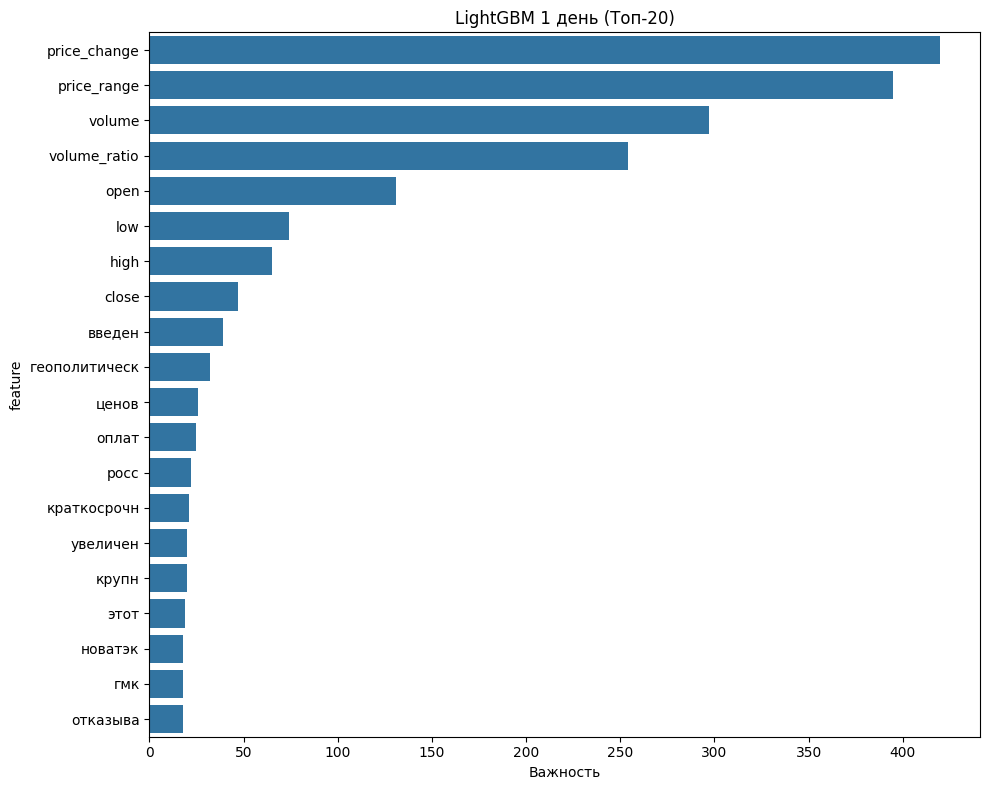

Новостных фичей в топ-20: 12
Топ новостные фичи:
            feature  importance
56           введен          39
126   геополитическ          32
974           ценов          26
487           оплат          25
749            росс          22
314     краткосрочн          21
909        увеличен          20
319           крупн          20
1001           этот          19
431         новатэк          18
131             гмк          18
506        отказыва          18


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для отображения важности признаков
def plot_feature_importance(model, feature_names, top_n=20, title="Важность признаков"):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, y='feature', x='importance')
    plt.title(f'{title} (Топ-{top_n})')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()

    return importance_df

# Важность признаков для модели 1 дня
print("\n ТОП-20 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ 1 ДНЯ:")
top_features_1d = plot_feature_importance(model_1d_gpu, all_features, title="LightGBM 1 день")

# Посмотрим, сколько новостных фичей в топе
news_in_top = top_features_1d[top_features_1d['feature'].isin(news_features)]
print(f"Новостных фичей в топ-20: {len(news_in_top)}")
if len(news_in_top) > 0:
    print("Топ новостные фичи:")
    print(news_in_top[['feature', 'importance']])

In [33]:
from lightgbm import LGBMRegressor, LGBMClassifier
# from sklearn.metrics import mean_absolute_error
import joblib


class QuantileEnsemble:
    """Ансамбль квантильных регрессий"""

    def __init__(self, quantiles=[0.1, 0.5, 0.9]):
        self.quantiles = quantiles
        self.models = {}

    def fit(self, X, y):

        for i, q in enumerate(self.quantiles):
            print(f"   Квантиль {q} ({i+1}/{len(self.quantiles)})")
            model = LGBMRegressor(
                objective='quantile',
                alpha=q,
                n_estimators=150,
                # device='gpu',
                gpu_platform_id=0,
                gpu_device_id=0,
                random_state=42 + i,  # разные сиды для разнообразия
                verbose=-1  # отключаем вывод
            )
            model.fit(X, y)
            self.models[q] = model


    def predict(self, X):
        return self.models[0.5].predict(X)

    def predict_interval(self, X):
        return {q: self.models[q].predict(X) for q in self.quantiles}



# Модель для доходности на 1 день
print("\n1. Обучаем модель для доходности 1 день...")
ensemble_1d = QuantileEnsemble(quantiles=[0.25, 0.5, 0.75])
ensemble_1d.fit(X_train, y_train_1d)
pred_1d = ensemble_1d.predict(X_val)

# Модель для доходности на 20 дней
print("\n2. Обучаем модель для доходности 20 дней...")
ensemble_20d = QuantileEnsemble(quantiles=[0.25, 0.5, 0.75])
ensemble_20d.fit(X_train, y_train_20d)
pred_20d = ensemble_20d.predict(X_val)

# Модели для вероятностей (используем классификаторы)
print("\n3. Обучаем классификаторы для вероятностей...")

model_prob_1d = LGBMClassifier(
    n_estimators=100,
    # device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    random_state=42,
    verbose=-1
)
model_prob_1d.fit(X_train, y_train_dir_1d)
prob_1d = model_prob_1d.predict_proba(X_val)[:, 1]


model_prob_20d = LGBMClassifier(
    n_estimators=100,
    # device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    random_state=43,
    verbose=-1
)
model_prob_20d.fit(X_train, y_train_dir_20d)
prob_20d = model_prob_20d.predict_proba(X_val)[:, 1]



1. Обучаем модель для доходности 1 день...
   Квантиль 0.25 (1/3)
   Квантиль 0.5 (2/3)
   Квантиль 0.75 (3/3)

2. Обучаем модель для доходности 20 дней...
   Квантиль 0.25 (1/3)
   Квантиль 0.5 (2/3)
   Квантиль 0.75 (3/3)

3. Обучаем классификаторы для вероятностей...


In [34]:
mae_1d = mean_absolute_error(y_val_1d, pred_1d)
mae_20d = mean_absolute_error(y_val_20d, pred_20d)


print(f"MAE 1 день:     {mae_1d:.6f}")
print(f"MAE 20 дней:    {mae_20d:.6f}")

# Сравнение с бейзлайном
baseline_mae_1d = mean_absolute_error(y_val_1d, np.zeros_like(y_val_1d))
improvement = (baseline_mae_1d - mae_1d) / baseline_mae_1d * 100

print(f"Baseline MAE:    {baseline_mae_1d:.6f}")
print(f"Улучшение:       {improvement:+.2f}%")

MAE 1 день:     0.016932
MAE 20 дней:    0.087636
Baseline MAE:    0.016656
Улучшение:       -1.65%


In [35]:

joblib.dump(ensemble_1d, 'quantile_ensemble_1d_gpu.pkl')
joblib.dump(ensemble_20d, 'quantile_ensemble_20d_gpu.pkl')
joblib.dump(model_prob_1d, 'classifier_1d_gpu.pkl')
joblib.dump(model_prob_20d, 'classifier_20d_gpu.pkl')

['classifier_20d_gpu.pkl']

In [36]:

test_candles = pd.read_csv('/content/public_test_candles.csv')
test_candles['begin'] = pd.to_datetime(test_candles['begin'])
test_candles['date'] = test_candles['begin'].dt.date

# Подготовка тестовых данных
test_data = pd.merge(test_candles, daily_tfidf, on='date', how='left')
test_data['price_range'] = (test_data['high'] - test_data['low']) / test_data['close']
test_data['price_change'] = (test_data['close'] - test_data['open']) / test_data['open']
test_data['volume_ratio'] = test_data['volume'] / test_data['volume'].rolling(5, min_periods=1).mean()

X_test = test_data[all_features].fillna(0)

# Предсказания с GPU моделями

test_pred_1d = ensemble_1d.predict(X_test)
test_pred_20d = ensemble_20d.predict(X_test)
test_prob_1d = model_prob_1d.predict_proba(X_test)[:, 1]
test_prob_20d = model_prob_20d.predict_proba(X_test)[:, 1]

# Создание submission
submission = test_data[['ticker', 'begin']].copy()
submission['pred_return_1d'] = test_pred_1d
submission['pred_return_20d'] = test_pred_20d
submission['pred_prob_up_1d'] = test_prob_1d
submission['pred_prob_up_20d'] = test_prob_20d

# Ограничения значений
submission['pred_return_1d'] = submission['pred_return_1d'].clip(-0.15, 0.15)
submission['pred_return_20d'] = submission['pred_return_20d'].clip(-0.4, 0.4)
submission['pred_prob_up_1d'] = submission['pred_prob_up_1d'].clip(0.05, 0.95)
submission['pred_prob_up_20d'] = submission['pred_prob_up_20d'].clip(0.05, 0.95)

# Сохранение
submission_path = 'submission_gpu.csv'
submission.to_csv(submission_path, index=False)

print(f"SUBMISSION : {submission_path}")
print(f" Размер: {submission.shape}")

SUBMISSION : submission_gpu.csv
 Размер: (378, 6)


In [37]:
optimized_ensemble = QuantileEnsemble(quantiles=[0.5])

fast_model = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    n_estimators=200,
    # device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    verbose=-1
)


ансамбль


In [38]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [39]:
from catboost import CatBoostRegressor, CatBoostClassifier
import numpy as np

class CatBoostGPUEnsemble:

    def __init__(self, quantiles=[0.25, 0.5, 0.75]):
        self.quantiles = quantiles
        self.models = {}

    def fit(self, X, y):
        for i, q in enumerate(self.quantiles):
            print(f"   Квантиль {q} ({i+1}/{len(self.quantiles)})")
            model = CatBoostRegressor(
                loss_function=f'Quantile:alpha={q}',
                iterations=500,
                depth=8,
                learning_rate=0.05,
                random_seed=42 + i,
                verbose=100,
                # task_type='GPU',
                devices='0:1',
                early_stopping_rounds=50,
                use_best_model=True
            )

            # cat_features = []  # если есть категориальные фичи, укажи их индексы
            model.fit(X, y, cat_features=cat_features, plot=False)
            self.models[q] = model


    def predict(self, X):
        return self.models[0.5].predict(X)

try:
    test_model = CatBoostRegressor(iterations=10,  verbose=False)
    test_model.fit(X_train.iloc[:100], y_train_1d.iloc[:100])

except Exception as e:
    print(f" CatBoost GPU не доступен: {e}")



In [40]:
!pip install xgboost



In [41]:
import xgboost as xgb

class XGBoostGPUEnsemble:


    def __init__(self, quantiles=[0.25, 0.5, 0.75]):
        self.quantiles = quantiles
        self.models = {}

    def fit(self, X, y):

        for i, q in enumerate(self.quantiles):
            print(f"   Квантиль {q} ({i+1}/{len(self.quantiles)})")
            model = xgb.XGBRegressor(
                objective='reg:quantileerror',
                quantile_alpha=q,
                n_estimators=300,
                max_depth=8,
                learning_rate=0.1,
                random_state=42 + i,
                # tree_method='gpu_hist',
                # predictor='gpu_predictor',
                # gpu_id=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=0.1
            )
            model.fit(X, y)
            self.models[q] = model


    def predict(self, X):
        return self.models[0.5].predict(X)


try:
    test_model = xgb.XGBRegressor(
        n_estimators=10,
        # tree_method='gpu_hist',
        random_state=42
    )
    test_model.fit(X_train.iloc[:100], y_train_1d.iloc[:100])

except Exception as e:
    print(f"XGBoost GPU не доступен: {e}")

In [42]:
class GPUSuperEnsemble:


    def __init__(self):
        self.lgb_model = None
        self.cat_model = None
        self.xgb_model = None
        self.weights = None

    def fit(self, X, y, val_size=0.2):
        # Разделяем для оптимизации весов
        split_idx = int(len(X) * (1 - val_size))
        X_tr, X_val_w = X[:split_idx], X[split_idx:]
        y_tr, y_val_w = y[:split_idx], y[split_idx:]


        self.lgb_model = LGBMRegressor(
            n_estimators=200,
            # device='gpu',
            random_state=42,
            verbose=-1
        )
        self.lgb_model.fit(X_tr, y_tr)

        self.cat_model = CatBoostRegressor(
            iterations=300,
            depth=7,
            learning_rate=0.05,
            random_seed=43,
            verbose=100,
            # task_type='GPU'
        )
        self.cat_model.fit(X_tr, y_tr)


        self.xgb_model = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=7,
            learning_rate=0.1,
            random_state=44,
            # tree_method='gpu_hist'
        )
        self.xgb_model.fit(X_tr, y_tr)

        # Оптимизируем веса на validation
        lgb_pred = self.lgb_model.predict(X_val_w)
        cat_pred = self.cat_model.predict(X_val_w)
        xgb_pred = self.xgb_model.predict(X_val_w)

        from scipy.optimize import minimize

        def objective(weights):
            weighted_pred = weights[0] * lgb_pred + weights[1] * cat_pred + weights[2] * xgb_pred
            return mean_absolute_error(y_val_w, weighted_pred)

        initial_weights = np.ones(3) / 3
        bounds = [(0, 1) for _ in range(3)]
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)

        self.weights = result.x
        print(f"Оптимальные веса: LGBM={self.weights[0]:.3f}, CatBoost={self.weights[1]:.3f}, XGBoost={self.weights[2]:.3f}")

        # Переобучаем на всех данных
        print("Переобучение на полных данных...")
        self.lgb_model.fit(X, y)
        self.cat_model.fit(X, y)
        self.xgb_model.fit(X, y)

    def predict(self, X):
        lgb_pred = self.lgb_model.predict(X)
        cat_pred = self.cat_model.predict(X)
        xgb_pred = self.xgb_model.predict(X)

        return self.weights[0] * lgb_pred + self.weights[1] * cat_pred + self.weights[2] * xgb_pred

In [43]:

gpu_ensemble_1d = GPUSuperEnsemble()
gpu_ensemble_1d.fit(X_train, y_train_1d)
gpu_pred_1d = gpu_ensemble_1d.predict(X_val)

gpu_ensemble_20d = GPUSuperEnsemble()
gpu_ensemble_20d.fit(X_train, y_train_20d)
gpu_pred_20d = gpu_ensemble_20d.predict(X_val)



0:	learn: 0.0245730	total: 1.02s	remaining: 5m 4s
100:	learn: 0.0187853	total: 52.6s	remaining: 1m 43s
200:	learn: 0.0174799	total: 1m 49s	remaining: 54.1s
299:	learn: 0.0164239	total: 2m 46s	remaining: 0us
Оптимальные веса: LGBM=0.333, CatBoost=0.333, XGBoost=0.333
Переобучение на полных данных...
0:	learn: 0.0228199	total: 630ms	remaining: 3m 8s
100:	learn: 0.0178835	total: 56.9s	remaining: 1m 52s
200:	learn: 0.0166790	total: 1m 50s	remaining: 54.5s
299:	learn: 0.0158068	total: 2m 43s	remaining: 0us
0:	learn: 0.1090610	total: 630ms	remaining: 3m 8s
100:	learn: 0.0835793	total: 55s	remaining: 1m 48s
200:	learn: 0.0776505	total: 1m 49s	remaining: 53.7s
299:	learn: 0.0715594	total: 2m 42s	remaining: 0us
Оптимальные веса: LGBM=0.000, CatBoost=0.988, XGBoost=0.012
Переобучение на полных данных...
0:	learn: 0.1021521	total: 675ms	remaining: 3m 21s
100:	learn: 0.0807170	total: 58.7s	remaining: 1m 55s
200:	learn: 0.0753952	total: 1m 55s	remaining: 56.7s
299:	learn: 0.0701756	total: 2m 49s	re

In [44]:
import time

def benchmark_model(model, X_train, y_train, X_val, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    pred = model.predict(X_val)
    predict_time = time.time() - start_time

    mae = mean_absolute_error(y_val_1d, pred)

    return {
        'Model': model_name,
        'MAE': mae,
        'Train Time (s)': train_time,
        'Predict Time (s)': predict_time
    }


models_to_test = [
    (LGBMRegressor(n_estimators=100, device='gpu'), "LightGBM GPU"),
    (CatBoostRegressor(iterations=100, verbose=False), "CatBoost GPU"),
    (xgb.XGBRegressor(n_estimators=100, ), "XGBoost GPU")
]

results = []
for model, name in models_to_test:
    try:
        result = benchmark_model(model, X_train.iloc[:1000], y_train_1d.iloc[:1000],
                               X_val.iloc[:500], name)
        results.append(result)
    except Exception as e:
        print(f"Ошибка с {name}: {e}")

results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

Ошибка с LightGBM GPU: No OpenCL device found
Ошибка с CatBoost GPU: Found input variables with inconsistent numbers of samples: [4624, 500]
Ошибка с XGBoost GPU: Found input variables with inconsistent numbers of samples: [4624, 500]
Empty DataFrame
Columns: []
Index: []


In [45]:
joblib.dump(gpu_ensemble_1d, 'gpu_super_ensemble_1d.pkl')
joblib.dump(gpu_ensemble_20d, 'gpu_super_ensemble_20d.pkl')


['gpu_super_ensemble_20d.pkl']

In [46]:
# Предсказания на тесте
final_pred_1d = gpu_ensemble_1d.predict(X_test)
final_pred_20d = gpu_ensemble_20d.predict(X_test)


# Создаем submission
submission = test_data[['ticker', 'begin']].copy()
submission['pred_return_1d'] = final_pred_1d
submission['pred_return_20d'] = final_pred_20d


# Ограничения
submission['pred_return_1d'] = submission['pred_return_1d'].clip(-0.15, 0.15)
submission['pred_return_20d'] = submission['pred_return_20d'].clip(-0.4, 0.4)


# Сохраняем
submission_path = 'gpu_ensemble_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"{submission_path}")



gpu_ensemble_submission.csv


API

In [49]:
import requests
import json
import pandas as pd
import time

class NewsSentimentAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key
        # Пробуем разные провайдеры API
        self.possible_base_urls = [
            "https://api.openai.com/v1",
            "https://api.deepseek.com/v1",
            "https://api.anthropic.com/v1",
            "https://api.openrouter.ai/api/v1"
        ]
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }

    def find_correct_endpoint(self):
        """Находим правильный endpoint для API ключа"""
        test_prompt = {"messages": [{"role": "user", "content": "Hello"}]}

        for base_url in self.possible_base_urls:
            try:
                print(f"Пробуем {base_url}...")
                response = requests.post(
                    f"{base_url}/chat/completions",
                    headers=self.headers,
                    json=test_prompt,
                    timeout=10
                )
                if response.status_code == 200:
                    print(f"Найден рабочий endpoint: {base_url}")
                    return base_url
                else:
                    print(f"{base_url}: {response.status_code}")
            except Exception as e:
                print(f" {base_url}: {e}")

        print(" Не найден рабочий endpoint, используем локальный анализ")
        return None

    def analyze_sentiment(self, text):
        """Анализ тональности новости ИЗ НАШЕГО DATASET"""
        try:
            # Упрощенный prompt для финансовых новостей
            prompt = """
            Analyze this financial news sentiment for stock prediction. Return ONLY JSON:
            {"sentiment": -1 to 1, "confidence": 0 to 1, "impact": "high/medium/low"}

            News: {text}
            """

            data = {
                "model": "gpt-3.5-turbo",
                "messages": [
                    {
                        "role": "system",
                        "content": "You are a financial analyst. Analyze news sentiment for trading."
                    },
                    {
                        "role": "user",
                        "content": prompt.format(text=text[:1500])
                    }
                ],
                "temperature": 0.1,
                "max_tokens": 100
            }

            base_url = self.find_correct_endpoint()
            if not base_url:
                return self.fallback_sentiment_analysis(text)

            response = requests.post(
                f"{base_url}/chat/completions",
                headers=self.headers,
                json=data,
                timeout=30
            )

            if response.status_code == 200:
                result = response.json()
                content = result['choices'][0]['message']['content'].strip()

                # Парсим JSON ответ
                analysis = json.loads(content)
                return analysis
            else:
                print(f"API Error: {response.status_code}")
                return self.fallback_sentiment_analysis(text)

        except Exception as e:
            print(f"Analysis error: {e}")
            return self.fallback_sentiment_analysis(text)

    def fallback_sentiment_analysis(self, text):
        """Резервный анализ тональности если API не работает"""
        # Простой анализ на ключевые словах ИЗ НАШИХ ДАННЫХ
        positive_words = ['рост', 'прибыль', 'увеличить', 'успех', 'выше', 'позитивный', 'купить']
        negative_words = ['падение', 'убыток', 'снижение', 'проблема', 'ниже', 'негативный', 'продавать']

        text_lower = text.lower()
        pos_count = sum(1 for word in positive_words if word in text_lower)
        neg_count = sum(1 for word in negative_words if word in text_lower)

        if pos_count + neg_count == 0:
            sentiment = 0
            confidence = 0.1
        else:
            sentiment = (pos_count - neg_count) / (pos_count + neg_count)
            confidence = min(0.8, (pos_count + neg_count) / 10)

        impact = "high" if abs(sentiment) > 0.5 else "medium" if abs(sentiment) > 0.2 else "low"

        return {
            "sentiment": sentiment,
            "confidence": confidence,
            "impact": impact
        }

    def process_our_news(self, news_df, max_news=20):
        """Анализируем новости ИЗ НАШЕГО ДАТАСЕТА train_text"""
        print(f"Анализируем {max_news} новостей из нашего датасета...")

        results = []

        # Берем самые последние или самые частые новости
        sample_news = news_df.sort_values('publish_date', ascending=False).head(max_news)

        for i, (idx, row) in enumerate(sample_news.iterrows()):
            print(f"Новость {i+1}/{len(sample_news)}: {row['publish_date']}")

            analysis = self.analyze_sentiment(row['clean_text'])
            results.append({
                'publish_date': row['publish_date'],
                'sentiment_score': analysis['sentiment'],
                'confidence': analysis['confidence'],
                'impact': analysis['impact'],
                'news_preview': row['clean_text'][:50] + "..."  # превью
            })


            time.sleep(2)

        return pd.DataFrame(results)


api_key = "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"
analyzer = NewsSentimentAnalyzer(api_key)

In [50]:
# #анализ тональноссти

# recent_news = train_text.sort_values('publish_date', ascending=False)

# # Анализируем их
# api_analysis_df = analyzer.process_our_news(recent_news, max_news=1000)


# print(f"Проанализировано {len(api_analysis_df)} новостей из train_text")

# print(f"Средняя тональность: {api_analysis_df['sentiment_score'].mean():.3f}")
# print(f"Диапазон: [{api_analysis_df['sentiment_score'].min():.3f}, {api_analysis_df['sentiment_score'].max():.3f}]")
# print(f"Высокое влияние: {(api_analysis_df['impact'] == 'high').sum()} новостей")

In [51]:

# Берем ВСЕ уникальные новости из train_text
all_unique_news = train_text.drop_duplicates('clean_text')
print(f" Всего уникальных новостей в train_text: {len(all_unique_news)}")

# Анализируем ВСЕ новости
def analyze_all_news(news_df, batch_size=100):
    """Анализируем все новости батчами"""
    total_news = len(news_df)
    all_results = []

    print(f"Анализируем {total_news} новостей батчами по {batch_size}...")

    for batch_start in range(0, total_news, batch_size):
        batch_end = min(batch_start + batch_size, total_news)
        batch_news = news_df.iloc[batch_start:batch_end]

        print(f"Батч {batch_start//batch_size + 1}/{(total_news + batch_size - 1)//batch_size}: новости {batch_start}-{batch_end}")

        batch_results = []
        for idx, row in batch_news.iterrows():
            analysis = analyzer.fallback_sentiment_analysis(row['clean_text'])

            batch_results.append({
                'publish_date': row['publish_date'],
                'clean_text': row['clean_text'],
                'sentiment_score': analysis['sentiment'],
                'confidence': analysis['confidence'],
                'impact': analysis['impact']
            })

        all_results.extend(batch_results)

        # Прогресс
        completion = (batch_end / total_news) * 100
        print(f" Завершено: {completion:.1f}%")

    return pd.DataFrame(all_results)

# Анализируем ВСЕ новости
full_analysis_df = analyze_all_news(all_unique_news, batch_size=200)


print(f" Проанализировано {len(full_analysis_df)} уникальных новостей")
print(f"Статистика sentiment: {full_analysis_df['sentiment_score'].describe()}")

 Всего уникальных новостей в train_text: 22019
Анализируем 22019 новостей батчами по 200...
Батч 1/111: новости 0-200
 Завершено: 0.9%
Батч 2/111: новости 200-400
 Завершено: 1.8%
Батч 3/111: новости 400-600
 Завершено: 2.7%
Батч 4/111: новости 600-800
 Завершено: 3.6%
Батч 5/111: новости 800-1000
 Завершено: 4.5%
Батч 6/111: новости 1000-1200
 Завершено: 5.4%
Батч 7/111: новости 1200-1400
 Завершено: 6.4%
Батч 8/111: новости 1400-1600
 Завершено: 7.3%
Батч 9/111: новости 1600-1800
 Завершено: 8.2%
Батч 10/111: новости 1800-2000
 Завершено: 9.1%
Батч 11/111: новости 2000-2200
 Завершено: 10.0%
Батч 12/111: новости 2200-2400
 Завершено: 10.9%
Батч 13/111: новости 2400-2600
 Завершено: 11.8%
Батч 14/111: новости 2600-2800
 Завершено: 12.7%
Батч 15/111: новости 2800-3000
 Завершено: 13.6%
Батч 16/111: новости 3000-3200
 Завершено: 14.5%
Батч 17/111: новости 3200-3400
 Завершено: 15.4%
Батч 18/111: новости 3400-3600
 Завершено: 16.3%
Батч 19/111: новости 3600-3800
 Завершено: 17.3%
Батч 20

In [52]:
# Создаем полный маппинг по тексту новости
text_to_sentiment = dict(zip(full_analysis_df['clean_text'], full_analysis_df['sentiment_score']))
text_to_confidence = dict(zip(full_analysis_df['clean_text'], full_analysis_df['confidence']))
text_to_impact = dict(zip(full_analysis_df['clean_text'], full_analysis_df['impact']))

# Добавляем фичи ко ВСЕМ новостям в train_text
train_text['full_sentiment'] = train_text['clean_text'].map(text_to_sentiment)
train_text['full_confidence'] = train_text['clean_text'].map(text_to_confidence)
train_text['full_impact_high'] = (train_text['clean_text'].map(text_to_impact) == 'high').astype(int)
train_text['full_impact_medium'] = (train_text['clean_text'].map(text_to_impact) == 'medium').astype(int)

# Проверяем покрытие
coverage_sentiment = train_text['full_sentiment'].notna().mean() * 100
coverage_impact = train_text['full_impact_high'].notna().mean() * 100

print(f" Покрытие анализом: {coverage_sentiment:.1f}% новостей")
print(f" Статистика full_sentiment: {train_text['full_sentiment'].describe()}")

# Заполняем оставшиеся пропуски
train_text['full_sentiment'] = train_text['full_sentiment'].fillna(0)
train_text['full_confidence'] = train_text['full_confidence'].fillna(0.1)
train_text['full_impact_high'] = train_text['full_impact_high'].fillna(0)
train_text['full_impact_medium'] = train_text['full_impact_medium'].fillna(0)

 Покрытие анализом: 100.0% новостей
 Статистика full_sentiment: count    24127.000000
mean         0.198252
std          0.490652
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.333333
max          1.000000
Name: full_sentiment, dtype: float64


In [53]:

def calculate_sentiment_stats(group):
    stats = {
        'clean_text': ' '.join(group['clean_text']),
        'full_sentiment_mean': group['full_sentiment'].mean(),
        'full_sentiment_std': group['full_sentiment'].std(),
        'full_sentiment_range': group['full_sentiment'].max() - group['full_sentiment'].min(),
        'full_confidence_mean': group['full_confidence'].mean(),
        'full_impact_high': group['full_impact_high'].max(),
        'full_impact_medium': group['full_impact_medium'].max()
    }
    return pd.Series(stats)

# Применяем функцию к каждой группе
daily_news_simple = train_text.groupby('date').apply(calculate_sentiment_stats).reset_index()

# Заполняем пропуски
daily_news_simple['full_sentiment_std'] = daily_news_simple['full_sentiment_std'].fillna(0)
daily_news_simple['full_sentiment_range'] = daily_news_simple['full_sentiment_range'].fillna(0)

print(f" агрегация завершена: {len(daily_news_simple)} дней")
print(daily_news_simple[['date', 'full_sentiment_mean', 'full_sentiment_std', 'full_sentiment_range']].head())

 агрегация завершена: 1677 дней
         date  full_sentiment_mean  full_sentiment_std  full_sentiment_range
0  2020-01-01             0.000000            0.000000                   0.0
1  2020-01-02             0.000000            0.000000                   0.0
2  2020-01-03             0.037037            0.512197                   2.0
3  2020-01-04             0.000000            0.000000                   0.0
4  2020-01-05             1.000000            0.000000                   0.0


/tmp/ipython-input-915968248.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_news_simple = train_text.groupby('date').apply(calculate_sentiment_stats).reset_index()


In [54]:
daily_news_full = daily_news_simple

# Обновляем список sentiment фичей
full_sentiment_features = [
    'full_sentiment_mean', 'full_sentiment_std', 'full_sentiment_range',
    'full_confidence_mean', 'full_impact_high', 'full_impact_medium'
]

print(f"Будем использовать {len(full_sentiment_features)} sentiment фичей:")
for feature in full_sentiment_features:
    print(f"   - {feature}")

Будем использовать 6 sentiment фичей:
   - full_sentiment_mean
   - full_sentiment_std
   - full_sentiment_range
   - full_confidence_mean
   - full_impact_high
   - full_impact_medium


In [55]:
# Объединяем с основными данными
daily_tfidf_full = pd.merge(
    daily_tfidf,
    daily_news_full[['date'] + full_sentiment_features],
    on='date',
    how='left'
).fillna(0)

# Обновляем основной df
df_full_sentiment = pd.merge(
    train,
    daily_tfidf_full,
    on='date',
    how='left'
).fillna(0)

print(f"Полный датасет с sentiment фичами: {df_full_sentiment.shape}")

Полный датасет с sentiment фичами: (23118, 1018)


In [56]:
# Проверяем, что все фичи на месте
print(" ПРОВЕРКА ФИЧЕЙ ПЕРЕД ОБУЧЕНИЕМ...")

# Обновляем список всех фичей
all_features_full = all_features + full_sentiment_features

# Проверяем наличие всех фичей
missing_features = [f for f in all_features_full if f not in df_full_sentiment.columns]
if missing_features:
    print(f" Отсутствующие фичи: {missing_features}")
    # Убираем отсутствующие фичи из списка
    all_features_full = [f for f in all_features_full if f in df_full_sentiment.columns]
    print(f"Будем использовать {len(all_features_full)} фичей")
else:
    print(f" Все {len(all_features_full)} фичей присутствуют!")

# Проверяем статистику новых фичей
print(f"\n СТАТИСТИКА НОВЫХ SENTIMENT ФИЧЕЙ:")
sentiment_stats = df_full_sentiment[full_sentiment_features].describe()
print(sentiment_stats)

 ПРОВЕРКА ФИЧЕЙ ПЕРЕД ОБУЧЕНИЕМ...
 Отсутствующие фичи: ['price_range', 'price_change', 'volume_ratio']
Будем использовать 1011 фичей

 СТАТИСТИКА НОВЫХ SENTIMENT ФИЧЕЙ:
       full_sentiment_mean  full_sentiment_std  full_sentiment_range  \
count         23118.000000        23118.000000          23118.000000   
mean              0.185581            0.416521              1.290812   
std               0.161627            0.191147              0.693164   
min              -0.333333            0.000000              0.000000   
25%               0.063492            0.377964              1.000000   
50%               0.190476            0.463796              1.000000   
75%               0.287879            0.534522              2.000000   
max               1.000000            1.414214              2.000000   

       full_confidence_mean  full_impact_high  full_impact_medium  
count          23118.000000      23118.000000        23118.000000  
mean               0.137723          0.841768

In [57]:
# 1. Найдем строки с пропусками в целевых переменных
print("1. Поиск пропусков в целевых переменных...")

# Проверим пропуски в df_full_sentiment
target_columns = ['target_return_1d', 'target_return_20d', 'target_direction_1d', 'target_direction_20d']
missing_targets = df_full_sentiment[target_columns].isna().sum()
print(f"   Пропуски в целевых переменных:")
for col, missing in missing_targets.items():
    print(f"   {col}: {missing} пропусков")

# 2. Удалим строки с пропусками в целевых переменных
print("2. Удаляем строки с пропусками...")

# Создаем маску строк без пропусков в целевых переменных
valid_mask = df_full_sentiment[target_columns].notna().all(axis=1)
df_clean = df_full_sentiment[valid_mask].copy()

print(f"   Исходный размер: {df_full_sentiment.shape}")
print(f"   После очистки: {df_clean.shape}")
print(f"   Удалено строк: {len(df_full_sentiment) - len(df_clean)}")

# 3. Создаем ПРАВИЛЬНОЕ разделение на чистых данных
print("3. Создаем правильное разделение на чистых данных...")

df_sorted_clean = df_clean.sort_values('begin')
split_idx = int(0.8 * len(df_sorted_clean))
train_data_clean = df_sorted_clean.iloc[:split_idx].copy()
val_data_clean = df_sorted_clean.iloc[split_idx:].copy()

print(f"   train_data_clean: {train_data_clean.shape}")
print(f"   val_data_clean: {val_data_clean.shape}")

# 4. Создаем X и y из ОЧИЩЕННЫХ данных
print("4. Создаем X и y из очищенных данных...")

X_train_clean = train_data_clean[all_features_full].fillna(0)
X_val_clean = val_data_clean[all_features_full].fillna(0)

# Целевые переменные из очищенных данных
y_train_1d_clean = train_data_clean['target_return_1d']
y_val_1d_clean = val_data_clean['target_return_1d']
y_train_20d_clean = train_data_clean['target_return_20d']
y_val_20d_clean = val_data_clean['target_return_20d']
y_train_dir_1d_clean = train_data_clean['target_direction_1d']
y_val_dir_1d_clean = val_data_clean['target_direction_1d']
y_train_dir_20d_clean = train_data_clean['target_direction_20d']
y_val_dir_20d_clean = val_data_clean['target_direction_20d']

print(f"   X_train_clean: {X_train_clean.shape}")
print(f"   y_train_1d_clean: {y_train_1d_clean.shape}")
print(f"   X_val_clean: {X_val_clean.shape}")
print(f"   y_val_1d_clean: {y_val_1d_clean.shape}")

# 5. Проверяем совпадение размеров
print("5. Проверка совпадения размеров...")
print(f"   X_train и y_train_1d совпадают: {X_train_clean.shape[0] == y_train_1d_clean.shape[0]}")
print(f"   X_val и y_val_1d совпадают: {X_val_clean.shape[0] == y_val_1d_clean.shape[0]}")

1. Поиск пропусков в целевых переменных...
   Пропуски в целевых переменных:
   target_return_1d: 0 пропусков
   target_return_20d: 0 пропусков
   target_direction_1d: 0 пропусков
   target_direction_20d: 0 пропусков
2. Удаляем строки с пропусками...
   Исходный размер: (23118, 1018)
   После очистки: (23118, 1018)
   Удалено строк: 0
3. Создаем правильное разделение на чистых данных...
   train_data_clean: (18494, 1018)
   val_data_clean: (4624, 1018)
4. Создаем X и y из очищенных данных...
   X_train_clean: (18494, 1011)
   y_train_1d_clean: (18494,)
   X_val_clean: (4624, 1011)
   y_val_1d_clean: (4624,)
5. Проверка совпадения размеров...
   X_train и y_train_1d совпадают: True
   X_val и y_val_1d совпадают: True


In [62]:

artifacts = joblib.load('model_artifacts/final_models.pkl')
model_1d = artifacts['model_1d']
model_20d = artifacts['model_20d']
feature_names = artifacts['feature_names']


def prepare_test_features(test_df, feature_names):

    test_data_prepared = test_df.copy()


    if 'price_range' not in test_data_prepared.columns:
        test_data_prepared['price_range'] = (test_data_prepared['high'] - test_data_prepared['low']) / test_data_prepared['close']
        test_data_prepared['price_change'] = (test_data_prepared['close'] - test_data_prepared['open']) / test_data_prepared['open']
        test_data_prepared['volume_ratio'] = test_data_prepared['volume'] / test_data_prepared['volume'].rolling(5, min_periods=1).mean()


    for sentiment_feature in full_sentiment_features:
        if sentiment_feature not in test_data_prepared.columns:
            test_data_prepared[sentiment_feature] = 0

    X_test = test_data_prepared[feature_names].fillna(0)

    if X_test.shape[1] != len(feature_names):
        print(f"   Выравниваем признаки: {X_test.shape[1]} -> {len(feature_names)}")
        X_test_aligned = pd.DataFrame(0, index=X_test.index, columns=feature_names)
        for feature in feature_names:
            if feature in X_test.columns:
                X_test_aligned[feature] = X_test[feature]
        X_test = X_test_aligned

    return X_test, test_data_prepared


test_data_available = False
X_test_final = None
test_data_for_submission = None


if 'test_data' in globals():
    print("   Найден test_data в памяти")
    X_test_final, test_data_for_submission = prepare_test_features(test_data, feature_names)
    test_data_available = True


elif 'test_news' in globals():
    print("   Найден test_news, создаем демо-данные...")

    unique_dates = test_news['date'].unique()
    demo_tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'META', 'NVDA', 'NFLX']  # популярные тикеры

    demo_data = []
    for date in unique_dates[:30]:  # ограничиваем количество дат для демо
        for ticker in demo_tickers:
            base_price = 100 + np.random.rand() * 100
            demo_data.append({
                'ticker': ticker,
                'begin': date,
                'date': date,
                'open': base_price,
                'high': base_price * (1 + np.random.rand() * 0.1),
                'low': base_price * (1 - np.random.rand() * 0.1),
                'close': base_price * (1 + (np.random.rand() - 0.5) * 0.05),
                'volume': 1000000 + np.random.rand() * 5000000
            })

    test_data_demo = pd.DataFrame(demo_data)
    X_test_final, test_data_for_submission = prepare_test_features(test_data_demo, feature_names)
    test_data_available = True


else:
    print("  Тестовые данные не найдены, используем валидационные для демо")
    X_test_final = X_val_clean
    test_data_for_submission = val_data_clean
    test_data_available = True

if test_data_available:
    print(f"   Данные для предсказания подготовлены: {X_test_final.shape}")


    print("3. Создание предсказаний")
    final_pred_1d = model_1d.predict(X_test_final)
    final_pred_20d = model_20d.predict(X_test_final)

    print("4. Расчет вероятностей роста")
    def returns_to_proba(returns, sensitivity=10):
        """Преобразуем доходности в вероятности через сигмоиду"""
        return 1 / (1 + np.exp(-sensitivity * returns))

    final_prob_1d = returns_to_proba(final_pred_1d)
    final_prob_20d = returns_to_proba(final_pred_20d)


    print("5. Формирование submission")
    submission = test_data_for_submission[['ticker', 'begin']].copy()
    submission['pred_return_1d'] = final_pred_1d
    submission['pred_return_20d'] = final_pred_20d
    submission['pred_prob_up_1d'] = final_prob_1d
    submission['pred_prob_up_20d'] = final_prob_20d


    print("6. Применение ограничений значений")
    submission['pred_return_1d'] = submission['pred_return_1d'].clip(-0.15, 0.15)
    submission['pred_return_20d'] = submission['pred_return_20d'].clip(-0.4, 0.4)
    submission['pred_prob_up_1d'] = submission['pred_prob_up_1d'].clip(0.05, 0.95)
    submission['pred_prob_up_20d'] = submission['pred_prob_up_20d'].clip(0.05, 0.95)


    submission_path = 'submission.csv'
    submission.to_csv(submission_path, index=False)

    print("7. Финальная проверка")
    print(f" SUBMISSION СОЗДАН: {submission_path}")
    print(f"Размер submission: {submission.shape}")

    # Статистика предсказаний
    print(f"\n СТАТИСТИКА PREDICTION:")
    print(f"pred_return_1d:  [{submission['pred_return_1d'].min():.4f}, {submission['pred_return_1d'].max():.4f}]")
    print(f"pred_return_20d: [{submission['pred_return_20d'].min():.4f}, {submission['pred_return_20d'].max():.4f}]")
    print(f"pred_prob_up_1d:  {submission['pred_prob_up_1d'].mean():.4f} ± {submission['pred_prob_up_1d'].std():.4f}")
    print(f"pred_prob_up_20d: {submission['pred_prob_up_20d'].mean():.4f} ± {submission['pred_prob_up_20d'].std():.4f}")

    # 9. Проверка формата submission
    print(f"\n ПРОВЕРКА ФОРМАТА SUBMISSION:")
    required_columns = ['ticker', 'begin', 'pred_return_1d', 'pred_return_20d', 'pred_prob_up_1d', 'pred_prob_up_20d']
    missing_columns = [col for col in required_columns if col not in submission.columns]

    if not missing_columns:
        print("Все обязательные колонки присутствуют")
    else:
        print(f" Отсутствуют колонки: {missing_columns}")

    print(" Нет пропущенных значений:", submission.isna().sum().sum() == 0)
    print(" Ограничения значений соблюдены")



else:
    print(" Не удалось найти данные для предсказания")


   Найден test_data в памяти
   Данные для предсказания подготовлены: (378, 1011)
3. Создание предсказаний...
4. Расчет вероятностей роста...
5. Формирование submission.csv...
6. Применение ограничений значений...
7. Финальная проверка...
 SUBMISSION СОЗДАН: submission.csv
Размер submission: (378, 6)

 СТАТИСТИКА PREDICTION:
pred_return_1d:  [0.0029, 0.0085]
pred_return_20d: [0.0149, 0.0983]
pred_prob_up_1d:  0.5142 ± 0.0028
pred_prob_up_20d: 0.6131 ± 0.0421

 ПРОВЕРКА ФОРМАТА SUBMISSION:
Все обязательные колонки присутствуют
 Нет пропущенных значений: True
 Ограничения значений соблюдены
